In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import itertools

In [2]:
# Load dataset
def load_data():
    """Load and preprocess the dataset."""

    df = pd.read_csv("hf://datasets/misikoff/SPX/^SPX.csv")
    df['Date'] = pd.to_datetime(df['Date'])

    df['Date_Original'] = df['Date']
    df.set_index('Date', inplace=True)
    df = df.sort_index()

    df = df[['Date_Original', 'Close']]
    return df

In [3]:
# Perform EDA and Handle Missing Data
def perform_eda(df):
    """Perform exploratory data analysis on the dataset."""

    print("Dataset Overview:\n", df.head())
    print("\nSummary Statistics:\n", df.describe())

    # Plot Closing Price over Time
    plt.figure(figsize=(12,6))
    plt.plot(df.index, df['Close'], label='Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.title('SPX Closing Price Over Time')
    plt.legend()
    plt.show()

    return df

In [4]:
# Train-Test Split
def train_test_split(df, test_ratio=0.2):
    """Split the dataset into training and testing sets."""

    split_idx = int(len(df) * (1 - test_ratio))
    train_df = df.iloc[:split_idx]
    test_df = df.iloc[split_idx:]
    return train_df, test_df

In [5]:
# Prepare Data for PyTorch
def prepare_data(df, seq_length=50, scaler=None, fit=True):
    """Prepare data for PyTorch model."""

    if scaler is None:
        scaler = MinMaxScaler()

    if fit:
        data_scaled = scaler.fit_transform(df[['Close']])
    else:
        data_scaled = scaler.transform(df[['Close']])

    X, y = [], []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i+seq_length])
        y.append(data_scaled[i+seq_length])
    
    X, y = np.array(X), np.array(y)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=32, shuffle=False), scaler

In [6]:
# Define RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        """Initialize RNN model."""
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout, nonlinearity='relu')
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        """Forward pass for the model."""
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Train Model
def train_model(model, train_loader, num_epochs=30, lr=0.001, device='cpu'):
    """Train the RNN model."""

    criterion = nn.MSELoss() # Mean Squared Error Loss
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam Optimizer
    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

    epoch_losses = []
    best_loss = float('inf')
    # Early stopping parameters
    patience_counter = 0
    patience_limit = 15

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss = 0.0  # Initialize total loss for the epoch

        # Iterate over batches
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            # Forward pass
            outputs = model(X_batch)
            # Compute loss
            loss = criterion(outputs, y_batch)
            # Backward pass and optimization
            loss.backward()
            # Update weights
            optimizer.step()
            total_loss += loss.item()  # Accumulate batch loss

        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping triggered.")
                break
        scheduler.step(avg_loss)

    # Plot training loss
    plt.figure()
    plt.plot(epoch_losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [8]:
def evaluate_model(model, test_loader, scaler, device='cpu'):
    """Evaluate the model on the test set."""

    model.eval()  # Set model to evaluation mode
    model = model.to(device)  # Ensure model is on the correct device

    predictions = []
    actuals = []

    # Print standard LSTM hyperparameters if applicable
    if isinstance(model, RNNModel):
        print("\nModel Type: Standard RNN")
        print(f"Hidden Size: {model.rnn.hidden_size}")
        print(f"Num Layers: {model.rnn.num_layers}")
        print(f"Dropout: {model.rnn.dropout}")

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    # Concatenate predictions and actuals
    predictions = np.concatenate(predictions).reshape(-1, 1)
    actuals = np.concatenate(actuals).reshape(-1, 1)

    # Inverse transform
    predictions = scaler.inverse_transform(predictions)
    actuals = scaler.inverse_transform(actuals)

    # Metrics
    mse = np.mean((predictions - actuals) ** 2)
    mae = np.mean(np.abs(predictions - actuals))
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Closing Prices on Test Set')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [9]:
def hyperparameter_tuning(train_df, device='cpu'):
    """Tune hyperparameters for the model."""

    param_grid = {
        'hidden_size': [32, 64, 96, 128],
        'num_layers': [1, 2],
        'dropout': [0.1, 0.3],
        'lr': [1e-3, 1e-4],
        'seq_length': [30, 50, 70]
    }

    best_loss = float('inf')
    best_params = None

    # Split the training data into a smaller training set and validation set
    train_sub, val_sub = train_test_split(train_df, test_ratio=0.2)

    # Iterate over all combinations of hyperparameters
    for hidden_size, num_layers, dropout, lr, seq_length in itertools.product(
        param_grid['hidden_size'], param_grid['num_layers'],
        param_grid['dropout'], param_grid['lr'], param_grid['seq_length']
    ):
        print(f"Trying config: hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}, seq_length={seq_length}")
        train_loader, scaler = prepare_data(train_sub, seq_length, fit=True)
        val_loader, _ = prepare_data(val_sub, seq_length, scaler=scaler, fit=False)

        model = RNNModel(hidden_size=hidden_size, num_layers=num_layers, dropout=dropout).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        for epoch in range(10):  # Short training during tuning
            model.train()
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        avg_loss = val_loss / len(val_loader)
        print(f"Avg Val Loss: {avg_loss:.4f}")

        # Check if this is the best configuration
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = (hidden_size, num_layers, dropout, lr, seq_length)

    print("\nBest config:")
    print(f"hidden_size={best_params[0]}, num_layers={best_params[1]}, dropout={best_params[2]}, lr={best_params[3]}, seq_length={best_params[4]}")
    # Return the best parameters
    return best_params

Using device: cuda
Dataset Overview:
            Date_Original      Close
Date                               
1927-12-30    1927-12-30  17.660000
1928-01-03    1928-01-03  17.760000
1928-01-04    1928-01-04  17.719999
1928-01-05    1928-01-05  17.549999
1928-01-06    1928-01-06  17.660000

Summary Statistics:
                        Date_Original         Close
count                          24167  24167.000000
mean   1976-03-09 19:45:41.374601728    617.896353
min              1927-12-30 00:00:00      4.400000
25%              1952-03-11 12:00:00     24.590000
50%              1976-04-13 00:00:00    101.949997
75%              2000-03-09 12:00:00   1003.494995
max              2024-03-15 00:00:00   5175.270020
std                              NaN    993.672669


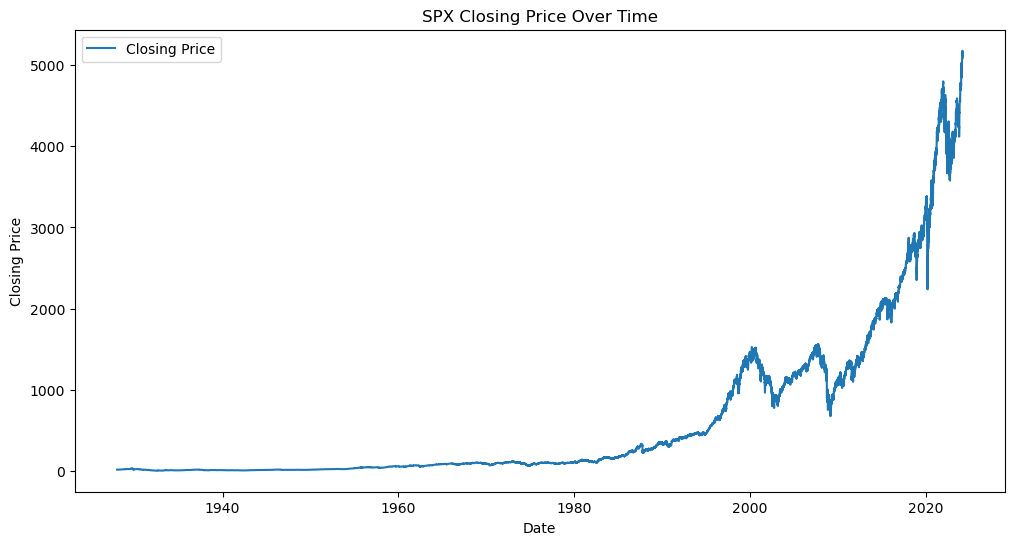

In [10]:
# Set device to use GPU if available, otherwise fallback to CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess data
df = load_data()
df = perform_eda(df)
train_df, test_df = train_test_split(df)

In [11]:
# Hyperparameter tuning to find the best configuration
best_params = hyperparameter_tuning(train_df, device=device)

Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1953
Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0021
Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0125
Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0029
Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.6995
Trying config: hidden_size=32, num_layers=1, dropout=0.1, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3711
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0822
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0149
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0060
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0449
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1926
Trying config: hidden_size=32, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.5961
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.001, seq_length=30
Avg Val Loss: 0.0099
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.001, seq_length=50
Avg Val Loss: 0.0028
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.001, seq_length=70
Avg Val Loss: 0.0029
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.0001, seq_length=30
Avg Val Loss: 0.8558
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.0001, seq_length=50
Avg Val Loss: 0.6642
Trying config: hidden_size=32, num_layers=2, dropout=0.1, lr=0.0001, seq_length=70
Avg Val Loss: 0.5130
Trying config: hidden_size=32, num_layers=2, dropout=0.3, lr=0.001, seq_length=30
Avg Val Loss: 0.3344
Trying config: hidden_size=32, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Val Loss: 0.1171
Trying config: hidden_size=32, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Val Loss: 0.2502
Trying config: hidden_size=32, num_layers=2, drop

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1120
Trying config: hidden_size=64, num_layers=1, dropout=0.1, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0385
Trying config: hidden_size=64, num_layers=1, dropout=0.1, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0056
Trying config: hidden_size=64, num_layers=1, dropout=0.1, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2747
Trying config: hidden_size=64, num_layers=1, dropout=0.1, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.4593
Trying config: hidden_size=64, num_layers=1, dropout=0.1, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.6383
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0680
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0345
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0036
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1416
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1767
Trying config: hidden_size=64, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3372
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.001, seq_length=30
Avg Val Loss: 0.4374
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.001, seq_length=50
Avg Val Loss: 0.2654
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.001, seq_length=70
Avg Val Loss: 0.1836
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.0001, seq_length=30
Avg Val Loss: 0.2310
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.0001, seq_length=50
Avg Val Loss: 0.4190
Trying config: hidden_size=64, num_layers=2, dropout=0.1, lr=0.0001, seq_length=70
Avg Val Loss: 0.4891
Trying config: hidden_size=64, num_layers=2, dropout=0.3, lr=0.001, seq_length=30
Avg Val Loss: 1.1802
Trying config: hidden_size=64, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Val Loss: 0.6842
Trying config: hidden_size=64, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Val Loss: 0.1777
Trying config: hidden_size=64, num_layers=2, drop

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0150
Trying config: hidden_size=96, num_layers=1, dropout=0.1, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2321
Trying config: hidden_size=96, num_layers=1, dropout=0.1, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1032
Trying config: hidden_size=96, num_layers=1, dropout=0.1, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1843
Trying config: hidden_size=96, num_layers=1, dropout=0.1, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3303
Trying config: hidden_size=96, num_layers=1, dropout=0.1, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0860
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2330
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3779
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.1056
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3899
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.5329
Trying config: hidden_size=96, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3365
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.001, seq_length=30
Avg Val Loss: 0.6294
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.001, seq_length=50
Avg Val Loss: 0.4085
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.001, seq_length=70
Avg Val Loss: 0.5134
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.0001, seq_length=30
Avg Val Loss: 0.3078
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.0001, seq_length=50
Avg Val Loss: 0.5173
Trying config: hidden_size=96, num_layers=2, dropout=0.1, lr=0.0001, seq_length=70
Avg Val Loss: 0.1573
Trying config: hidden_size=96, num_layers=2, dropout=0.3, lr=0.001, seq_length=30
Avg Val Loss: 0.5164
Trying config: hidden_size=96, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Val Loss: 0.2932
Trying config: hidden_size=96, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Val Loss: 0.2684
Trying config: hidden_size=96, num_layers=2, drop

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3132
Trying config: hidden_size=128, num_layers=1, dropout=0.1, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2668
Trying config: hidden_size=128, num_layers=1, dropout=0.1, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2639
Trying config: hidden_size=128, num_layers=1, dropout=0.1, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.4198
Trying config: hidden_size=128, num_layers=1, dropout=0.1, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2171
Trying config: hidden_size=128, num_layers=1, dropout=0.1, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0248
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3671
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.3940
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0423
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.0001, seq_length=30


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0890
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.0001, seq_length=50


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.2507
Trying config: hidden_size=128, num_layers=1, dropout=0.3, lr=0.0001, seq_length=70


/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


Avg Val Loss: 0.0323
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.001, seq_length=30
Avg Val Loss: 0.4516
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.001, seq_length=50
Avg Val Loss: 0.4778
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.001, seq_length=70
Avg Val Loss: 0.9433
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.0001, seq_length=30
Avg Val Loss: 0.2880
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.0001, seq_length=50
Avg Val Loss: 0.1842
Trying config: hidden_size=128, num_layers=2, dropout=0.1, lr=0.0001, seq_length=70
Avg Val Loss: 0.0751
Trying config: hidden_size=128, num_layers=2, dropout=0.3, lr=0.001, seq_length=30
Avg Val Loss: 0.9244
Trying config: hidden_size=128, num_layers=2, dropout=0.3, lr=0.001, seq_length=50
Avg Val Loss: 1.2453
Trying config: hidden_size=128, num_layers=2, dropout=0.3, lr=0.001, seq_length=70
Avg Val Loss: 1.6999
Trying config: hidden_size=128, num_laye

/home/jatinj/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
/home/jatinj/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Loss: 0.0006
Epoch [2/30], Loss: 0.0042
Epoch [3/30], Loss: 0.0026
Epoch [4/30], Loss: 0.0022
Epoch [5/30], Loss: 0.0015
Epoch [6/30], Loss: 0.0024
Epoch [7/30], Loss: 0.0034
Epoch [8/30], Loss: 0.0013
Epoch [9/30], Loss: 0.0004
Epoch [10/30], Loss: 0.0001
Epoch [11/30], Loss: 0.0001
Epoch [12/30], Loss: 0.0000
Epoch [13/30], Loss: 0.0000
Epoch [14/30], Loss: 0.0000
Epoch [15/30], Loss: 0.0000
Epoch [16/30], Loss: 0.0000
Epoch [17/30], Loss: 0.0000
Epoch [18/30], Loss: 0.0000
Epoch [19/30], Loss: 0.0000
Epoch [20/30], Loss: 0.0001
Epoch [21/30], Loss: 0.0000
Epoch [22/30], Loss: 0.0001
Epoch [23/30], Loss: 0.0000
Epoch [24/30], Loss: 0.0000
Epoch [25/30], Loss: 0.0000
Epoch [26/30], Loss: 0.0000
Epoch [27/30], Loss: 0.0000
Epoch [28/30], Loss: 0.0002
Epoch [29/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000


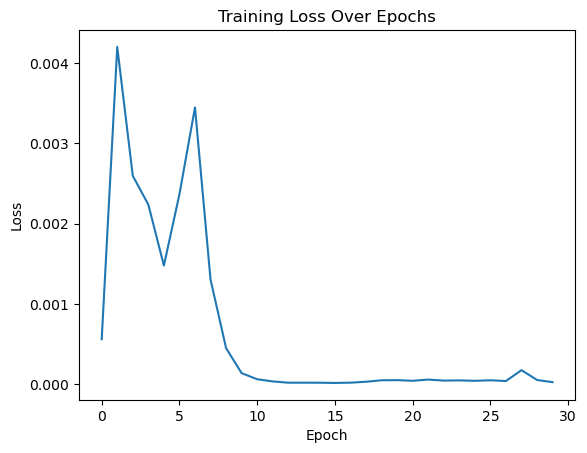


Model Type: Standard RNN
Hidden Size: 32
Num Layers: 1
Dropout: 0.1
Learning Rate: 0.001
Window Length: 50


In [20]:
# Train the model with the best parameters
train_loader, scaler = prepare_data(train_df, seq_length=best_params[4])
model = RNNModel(hidden_size=best_params[0], num_layers=best_params[1], dropout=best_params[2]).to(device)
train_model(model, train_loader, lr=best_params[3], device=device)

print("\nModel Type: Standard RNN")
print(f"Hidden Size: {best_params[0]}")
print(f"Num Layers: {best_params[1]}")
print(f"Dropout: {best_params[2]}")
print(f"Learning Rate: {best_params[3]}")
print(f"Window Length: {best_params[4]}")

Test MSE: 1752.9604
Test MAE: 25.1464


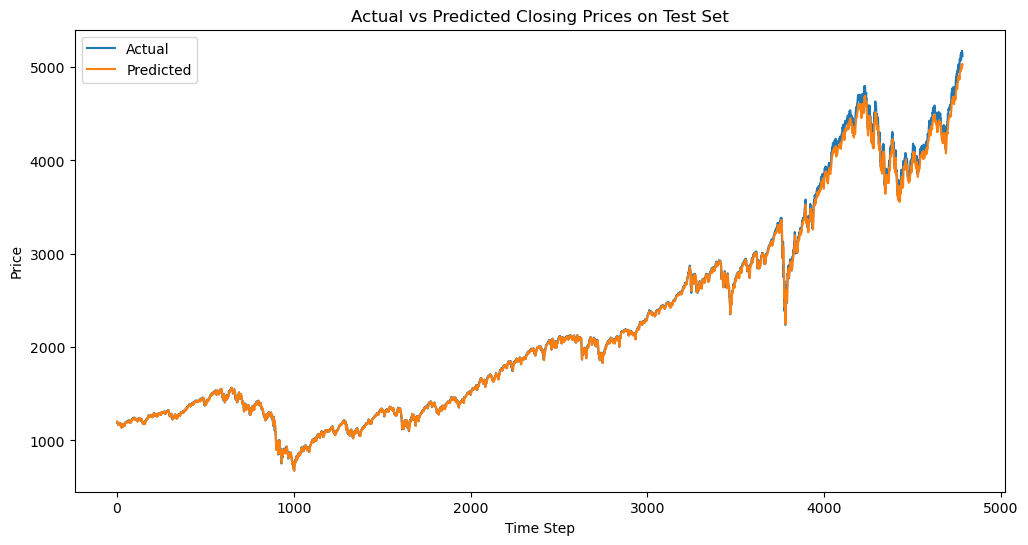

In [21]:
# Prepare test data for evaluation
test_loader, _ = prepare_data(test_df, seq_length=best_params[4], scaler=scaler, fit=False)
# Evaluate the model on the test set
evaluate_model(model, test_loader, scaler)